In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        for t in itertools.count():
            future_s, r, done, _ = env.step(action)

            future_action_p = policy(future_s)
            future_action = np.random.choice(np.arange(len(future_action_p)), p=future_action_p)

            stats.episode_rewards[i_episode] += r
            stats.episode_lengths[i_episode] = t
            
            td_target = r + discount_factor * Q[future_s][future_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = future_action
            state = future_s
    
    return Q, stats

In [5]:
Q, stats = sarsa(env, 200)

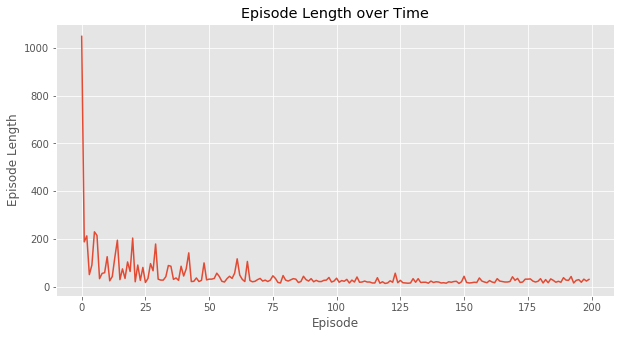

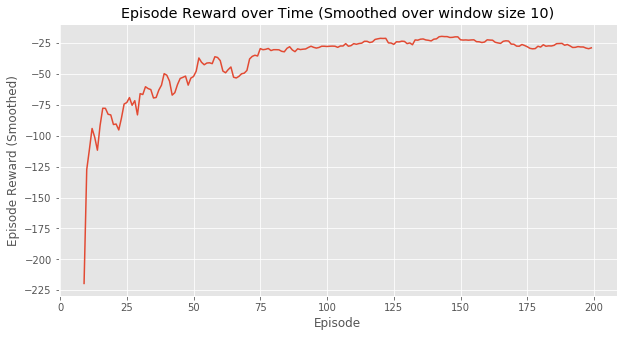

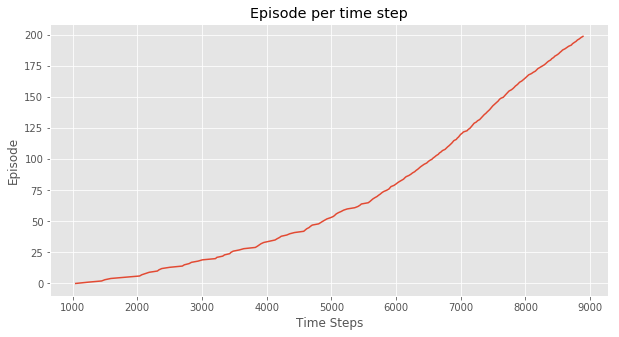

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)